In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [355]:
df = pd.read_csv('0050.TW.csv', index_col=0)
df = df.round(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 2023-03-22 to 2024-03-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       244 non-null    float64
 1   High       244 non-null    float64
 2   Low        244 non-null    float64
 3   Close      244 non-null    float64
 4   Adj Close  244 non-null    float64
 5   Volume     244 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.3+ KB


In [356]:
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,Open,High,Low,Close,Adj Close,Volume
2023-03-22,119.45,120.90,119.45,120.90,116.444,14242127
2023-03-23,120.65,122.30,120.45,121.85,117.359,15532979
2023-03-24,122.00,122.30,121.55,122.20,117.696,13457394
2023-03-27,121.75,121.90,121.20,121.45,116.974,10644595
2023-03-28,120.95,121.15,120.20,120.40,115.963,9741489


# FUNTION Def

In [357]:
def getData(df, feature_columns, label_column, train_end=-30, days_before=30, standardize=True):
    series = df.copy()
    mean = series.mean()
    std = series.std()
    if standardize:
        series = (series - mean)/std

    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series = series[feature_columns][:train_end]
    # 创建训练集
    train_feature = pd.DataFrame()
    train_label = pd.DataFrame()

    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
    # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
    # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
    # 比如从 [2:-7+2]，其长度为 len - 7
        train_feature['bday%d' % i] = train_series[i: -days_before + i].values.tolist()

    # 获取对应的 label
    train_label['y'] = series[label_column].to_numpy()[days_before:]
    #print(train_data["bday4"])
    return train_feature, train_label, df.index.tolist()

In [358]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(
          input_size=len(FEATURES),
          hidden_size=64,
          num_layers=2,
          batch_first=True)

        self.linear = nn.Linear(64,1)

    def predict(self, input):
        with torch.no_grad():
            return self.forward(input)

    def forward(self, x):
        r_out, (h_n, c_n) = self.lstm(x, None)  # None 表示 hidden state 会用全 0 的 state
        out = self.linear(r_out)     # 取最后一天作为输出
        return out, (h_n,c_n)

In [359]:
class TrainSet(Dataset):
    def __init__(self, x, y):
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = x[:, :-1].float(), y[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [360]:
#Make test set for testing
def getTestData(df, feature_columns, label_column, train_end=-30, days_before=30, standardize=True):
    series = df.copy()
    mean = series.mean()
    std = series.std()
    if standardize:
        series = (series - mean)/std

    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    test_series = series[feature_columns][train_end-days_before:]
    # 创建训练集
    test_feature = pd.DataFrame()
    test_label = pd.DataFrame()

    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
        # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
        # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
        # 比如从 [2:-7+2]，其长度为 len - 7

        test_feature['bday%d' % i] = test_series[i: -days_before + i].values.tolist()

    # 获取对应的 label
    test_label['y'] = series[label_column].to_numpy()[days_before:]
    #print(train_data["bday4"])
    return test_feature, test_label, df.index.tolist()

# ALL FEATURE

In [361]:
LR = 0.0001
EPOCH = 1000
BATCH_SIZE = 200
TRAIN_END=-1
DAYS_BEFORE=7
FEATURES = [ "Open", "High", "Low",	"Close", "Adj Close", "Volume"]
feature_index = {feature: index for index, feature in enumerate(FEATURES)}
rnns = {feature: LSTM() for feature in FEATURES}

# Open

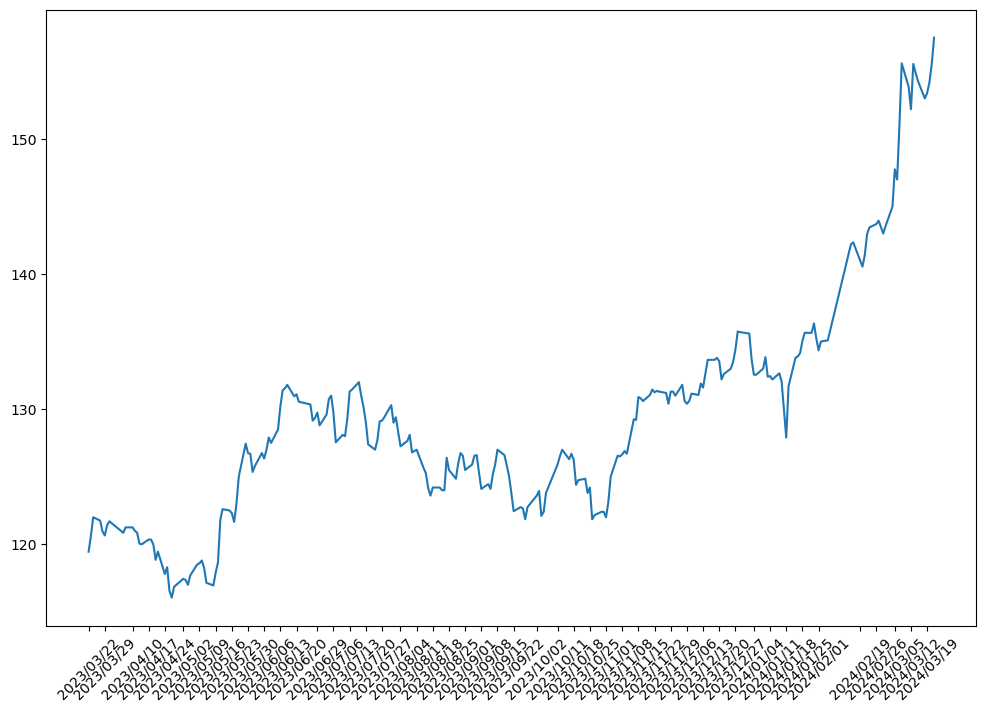

In [362]:
LABEL =  "Open"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.003769179880619049
1 0.009558396935462952
2 0.0020711570978164673
3 0.0037118470668792724
4 0.004054607152938843
5 0.006084036231040955
6 0.0050966602563858035
7 0.00506642997264862
8 0.008526397347450256
9 0.0030207136273384095
10 0.005563576221466065
11 0.0045045197010040285
12 0.006627967357635498
13 0.004259157180786133
14 0.005636627674102783
15 0.003641493022441864
16 0.0035387519001960754
17 0.0031989291310310364
18 0.004194446802139282
19 0.005291927456855774
20 0.0023416858911514283
21 0.004463581442832947
22 0.006239480972290039
23 0.0033074414730072024
24 0.004196900427341461
25 0.004325249791145324
26 0.0030349451303482056
27 0.002106005847454071
28 0.0034094488620758055
29 0.0028939181566238403
30 0.003187677264213562
31 0.0020140939950942993
32 0.003954263925552368
33 0.0025443071126937866
34 0.0040407881140708925
35 0.0016684482991695404
36 0.004871784448623657
37 0.0021314999461174012
38 0.003039570450782776
39 0.002140273451805115
40 0.00422110915184021
41 0.003645

318 0.00021272869780659677
319 0.0003686121851205826
320 0.00029644422233104706
321 0.00026373978704214096
322 0.0003104846738278866
323 0.00020299293100833893
324 0.00023623242974281312
325 0.0003994069993495941
326 0.00029688967391848563
327 0.0001653761975467205
328 0.00032470695674419403
329 0.0002487591654062271
330 0.0002089024521410465
331 0.000319504477083683
332 0.0003617074340581894
333 0.00026036381721496584
334 0.00020132269710302353
335 0.0003576561808586121
336 0.0003721903637051582
337 0.0003121899254620075
338 0.0002736792154610157
339 0.00028740482404828073
340 0.000339193195104599
341 0.00023748578503727914
342 0.00026711583137512207
343 0.00023603826761245728
344 0.00022790458053350448
345 0.00020345760509371758
346 0.0002673676982522011
347 0.0002697695046663284
348 0.0003057847730815411
349 0.0002108781412243843
350 0.0001941918581724167
351 0.00019531713798642158
352 0.00021534088999032973
353 0.0002396533451974392
354 0.0002022753842175007
355 0.00022065971046686

627 0.00023195577785372734
628 0.0002105662226676941
629 0.0002328972890973091
630 0.0002041928470134735
631 0.000249113030731678
632 0.00020030325278639794
633 0.00030574036762118337
634 0.00016095707193017006
635 0.00018900442868471145
636 0.0002968156710267067
637 0.0002237958647310734
638 0.00024604855105280876
639 0.00022758770734071732
640 0.00030197978019714356
641 0.00019039023667573928
642 0.00020685262978076935
643 0.00022372290492057802
644 0.00015790309756994248
645 0.00032626062631607055
646 0.00018217287957668306
647 0.0002018076553940773
648 0.00019737822934985162
649 0.00018668824806809426
650 0.0001661710999906063
651 0.0002787970192730427
652 0.00026082850992679594
653 0.00018420930951833724
654 0.00022045886144042015
655 0.0001711147278547287
656 0.00026931056752800943
657 0.00026835324242711065
658 0.0002192021906375885
659 0.00029965056106448176
660 0.00022457079961895942
661 0.000193557757884264
662 0.00025748895481228826
663 0.00023278802633285522
664 0.000174476

936 0.00022511620074510574
937 0.00021595008671283723
938 0.00015446199104189872
939 0.00022566033527255059
940 0.00021373797208070754
941 0.0001842801459133625
942 0.00020625276491045952
943 0.0001466432586312294
944 0.00014059321954846383
945 0.00020438076928257942
946 0.00013636716641485692
947 0.0001532786712050438
948 0.00021512128412723541
949 0.00018309347331523895
950 0.00013483574613928795
951 0.00012617092579603195
952 0.0001444969605654478
953 0.0003608382865786552
954 0.00021182011812925338
955 0.00025784607976675033
956 0.00033423122018575666
957 0.00016799800097942353
958 0.0002343425154685974
959 0.00025636253878474235
960 0.0001404884923249483
961 0.00013425261713564395
962 0.00030063603073358534
963 0.00016559019684791565
964 0.00020006176084280013
965 0.00014934703707695008
966 0.0002760746330022812
967 0.00020413091406226158
968 0.00019263867288827897
969 0.00018761675804853439
970 0.00018371505662798882
971 0.00016909923404455186
972 0.00026176245883107184
973 0.000

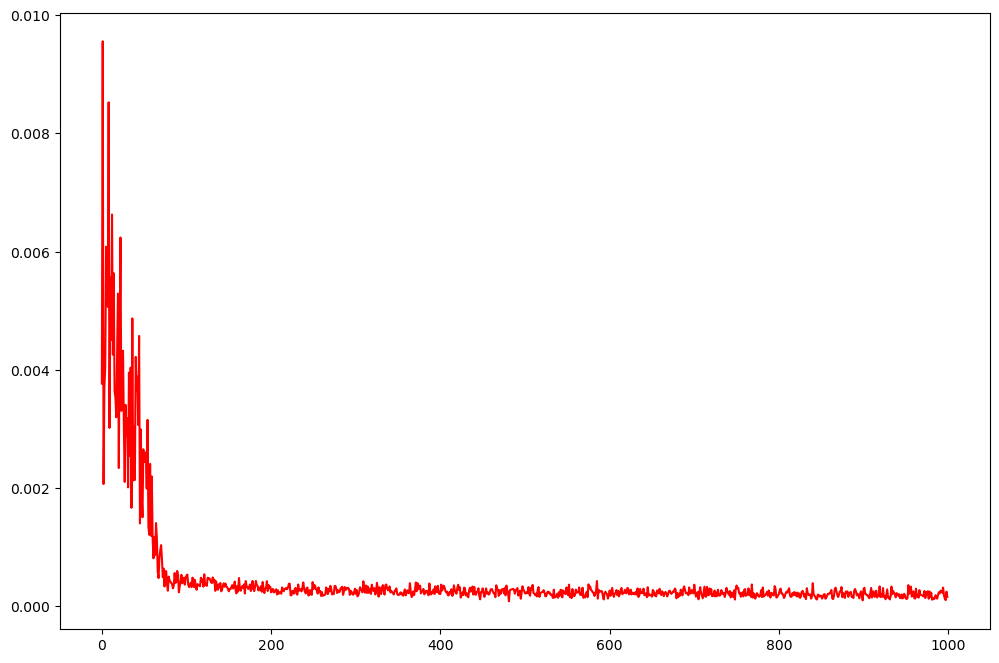

In [363]:
#訓練
# rnns[LABEL] = torch.load('rnn.pkl')

losses = []

optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [364]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

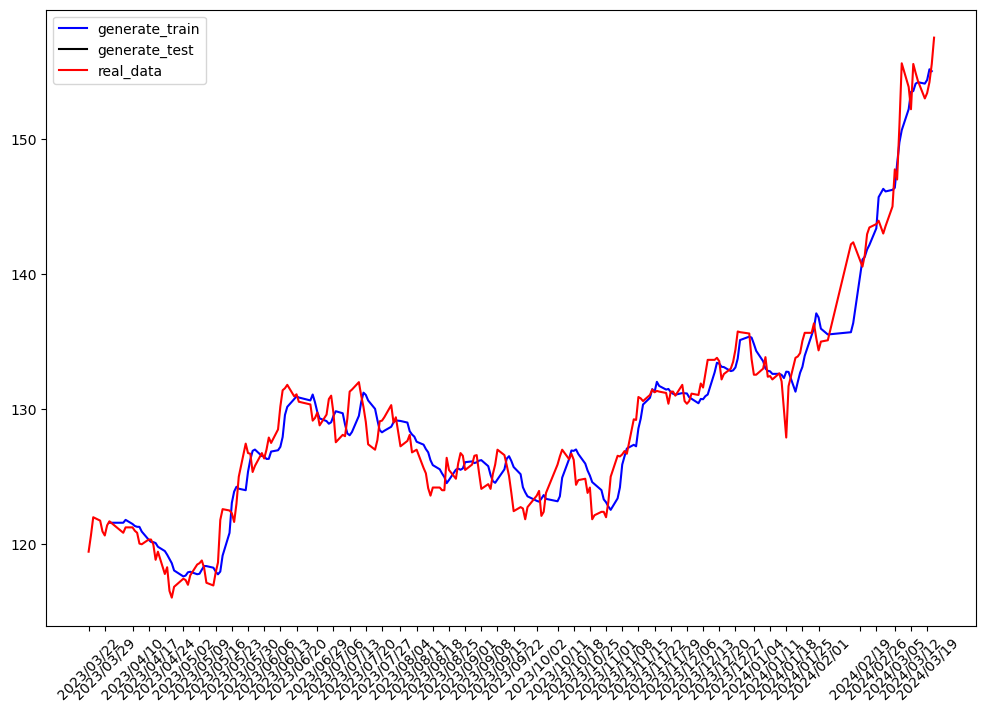

In [365]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


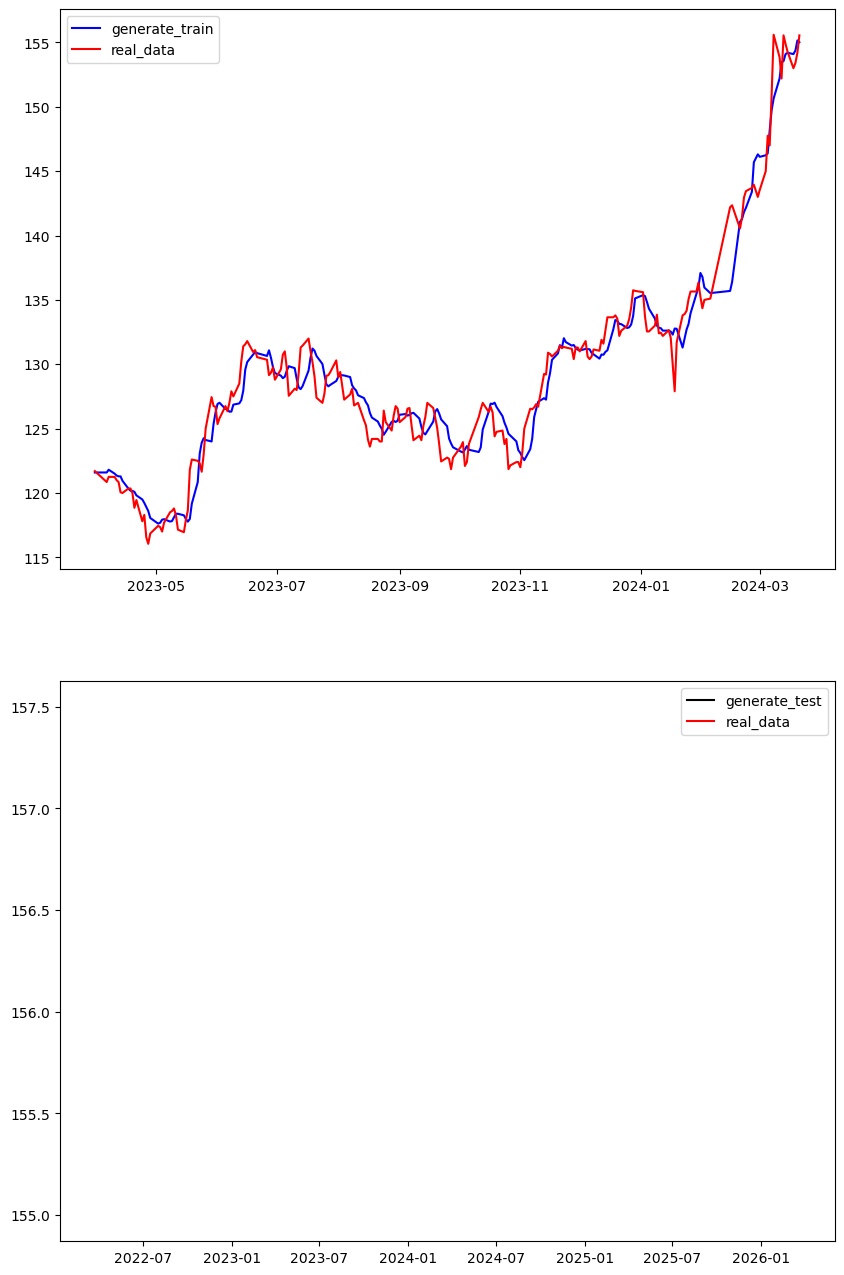

In [366]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# High

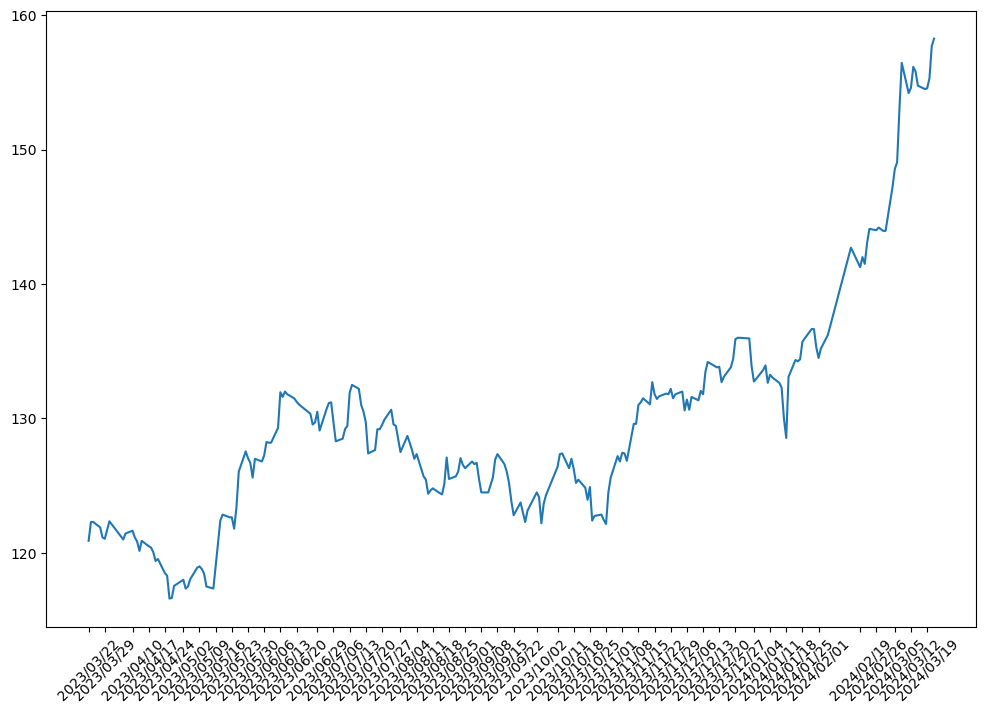

In [367]:
LABEL =  "High"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.006484000086784363
1 0.006566011905670166
2 0.005250337123870849
3 0.00533233106136322
4 0.0017830505967140198
5 0.004334222376346588
6 0.008782880306243896
7 0.005072242617607117
8 0.005551797747612
9 0.005469791293144226
10 0.0068126791715621944
11 0.004159348011016846
12 0.004332304894924164
13 0.001765463501214981
14 0.004600797891616821
15 0.007833861112594605
16 0.004861465692520142
17 0.00612508237361908
18 0.0036840927600860596
19 0.0031765961647033693
20 0.001838485449552536
21 0.004666549861431122
22 0.008722190260887146
23 0.00446263313293457
24 0.005678456425666809
25 0.002756691575050354
26 0.004501842260360718
27 0.004639897346496582
28 0.006398370265960693
29 0.002739030122756958
30 0.004723203480243683
31 0.001553042083978653
32 0.004522478878498077
33 0.005076005458831787
34 0.0036395719647407533
35 0.005010998249053955
36 0.0038052019476890564
37 0.00249115526676178
38 0.0026418158411979677
39 0.002141089141368866
40 0.005595185160636902
41 0.0037863388657569884
4

318 0.00022041980177164077
319 0.0002270265109837055
320 0.00023697854951024055
321 0.0003156663849949837
322 0.00020584629848599434
323 0.00022709583863615989
324 0.00020137447863817216
325 0.00027962502092123033
326 0.00018833009526133537
327 0.00029470255598425867
328 0.0002724551782011986
329 0.00024606527760624887
330 0.00021160639822483064
331 0.00022984392940998078
332 0.00029850849881768226
333 0.00026131875813007355
334 0.00020762888714671136
335 0.00019391078501939773
336 0.00031548164784908297
337 0.00026820385828614236
338 0.00019233431667089462
339 0.00025471018627285956
340 0.00030709872022271155
341 0.00030429529026150705
342 0.0002670746110379696
343 0.00015366179868578911
344 0.0002957247756421566
345 0.00018664708361029625
346 0.0002632789500057697
347 0.00014464717358350754
348 0.0002960803732275963
349 0.00022680850699543953
350 0.00015857484191656113
351 0.00027929531410336494
352 0.0002519507147371769
353 0.00029668871313333513
354 0.0002699936367571354
355 0.0002

627 0.0002461460791528225
628 0.00018970072269439698
629 0.0002706882171332836
630 0.0002786477655172348
631 0.00021775742992758752
632 0.00023577924817800523
633 0.0002149573527276516
634 0.0002037416212260723
635 0.00014419924467802049
636 0.0002731572650372982
637 0.0002099785953760147
638 0.00019297592341899872
639 0.0002552536502480507
640 0.00027509914711117746
641 0.0001243110653012991
642 0.00021517075598239898
643 0.00021182406693696974
644 0.00021872494369745254
645 0.00016102859750390054
646 0.0001242954283952713
647 0.0002964834123849869
648 0.0001934780739247799
649 0.00023844162002205848
650 0.0001213129237294197
651 0.0002506484277546406
652 0.000281477402895689
653 0.0002656906098127365
654 0.00028925379738211634
655 0.0001893877238035202
656 0.0001848641037940979
657 0.0001965154893696308
658 0.00025994811207056043
659 0.00021735288202762604
660 0.00028550168499350546
661 0.00020371126011013984
662 0.0003508656471967697
663 0.00014750558882951738
664 0.0001721848733723

937 0.00017861537635326384
938 0.0003293269127607346
939 0.00022761760279536248
940 0.00015987075865268708
941 0.00024473296478390695
942 0.00015965480357408524
943 0.00020593874156475068
944 0.0001544170081615448
945 0.000279938280582428
946 0.00014058202505111693
947 0.00018318835645914078
948 0.00017635056748986245
949 0.00033581700176000596
950 0.0001995173841714859
951 0.0001700413227081299
952 0.0002367602102458477
953 0.0001271244417876005
954 0.0002061854861676693
955 0.00016890516504645348
956 0.00021114638075232507
957 0.00018527809530496597
958 0.00016977746039628983
959 0.00032343611121177674
960 0.00013477879576385022
961 0.00022124016657471657
962 0.0001389298867434263
963 0.00019891178235411643
964 0.00023227540776133538
965 0.0002587590552866459
966 0.00021339796483516694
967 0.00016703274101018906
968 0.00034544691443443297
969 0.00023634668439626694
970 0.00016645876690745353
971 0.00022021476179361342
972 0.0002644738182425499
973 0.00020417995750904083
974 0.0003288

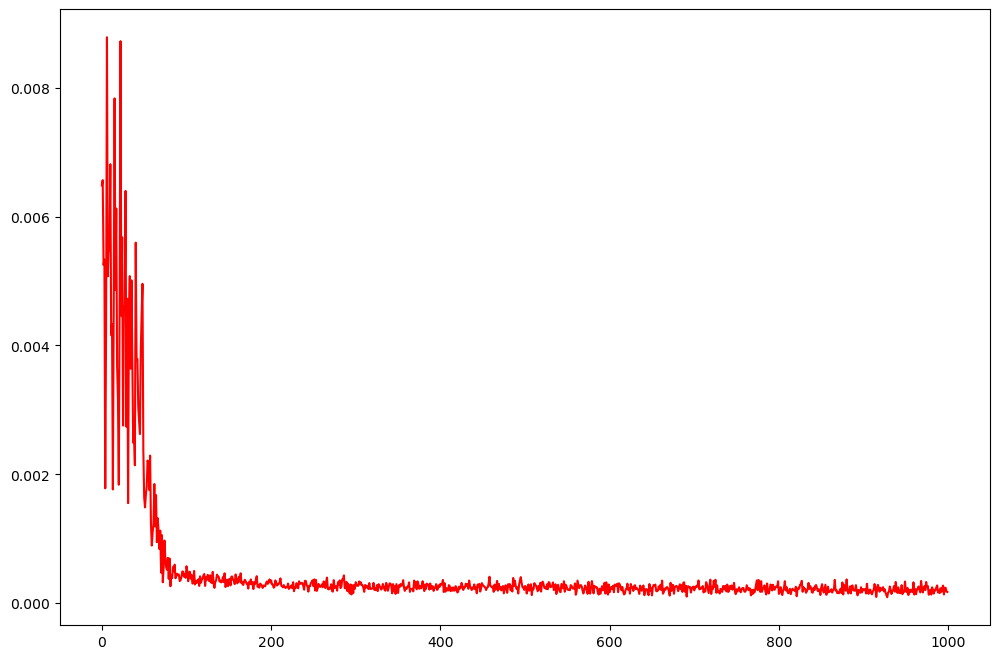

In [368]:
#訓練
# rnns[LABEL] = torch.load('rnn.pkl')

losses = []


optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [369]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

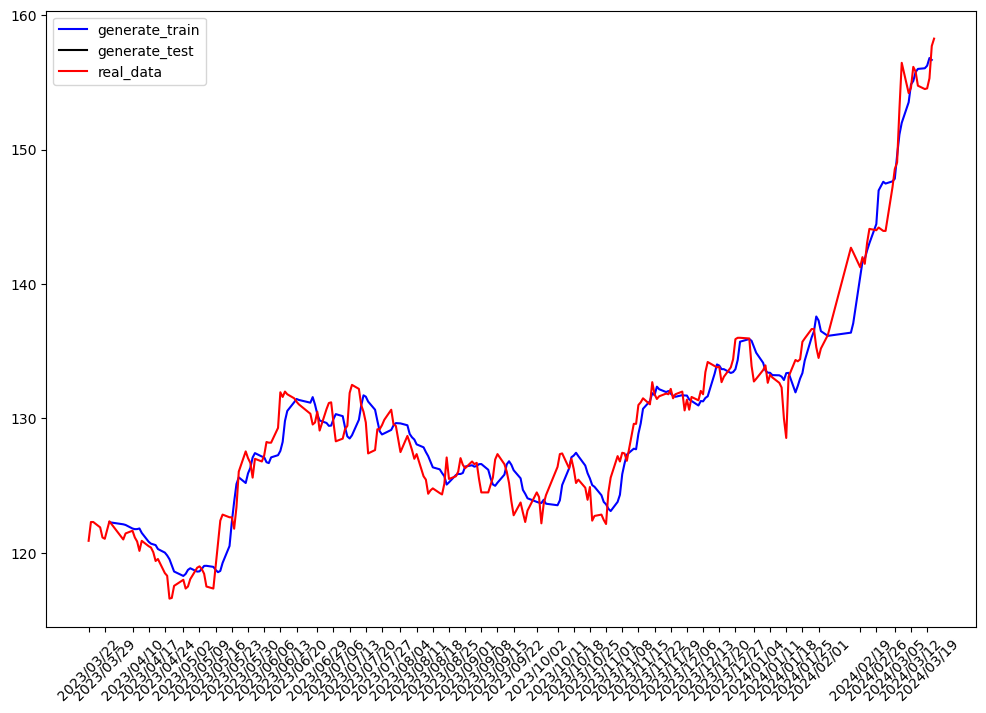

In [370]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


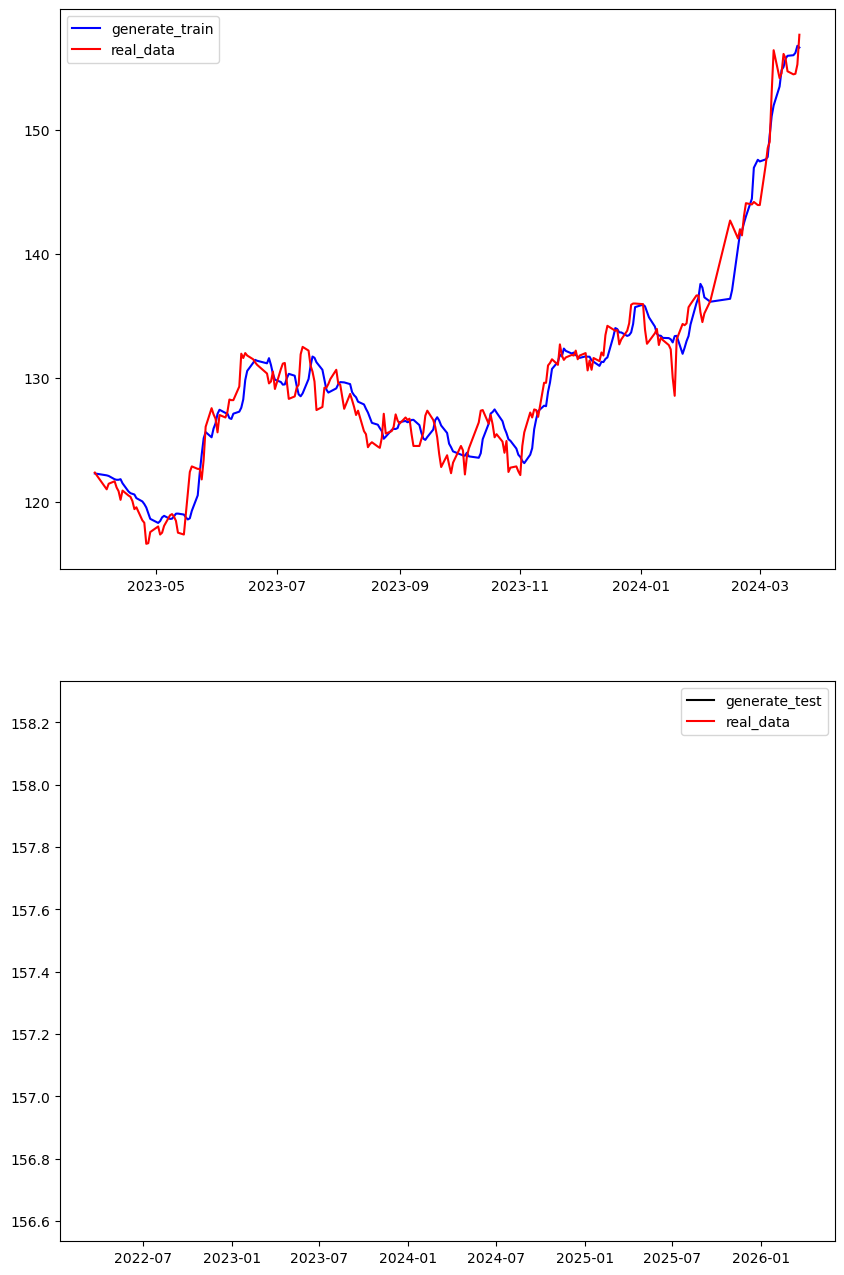

In [371]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Low

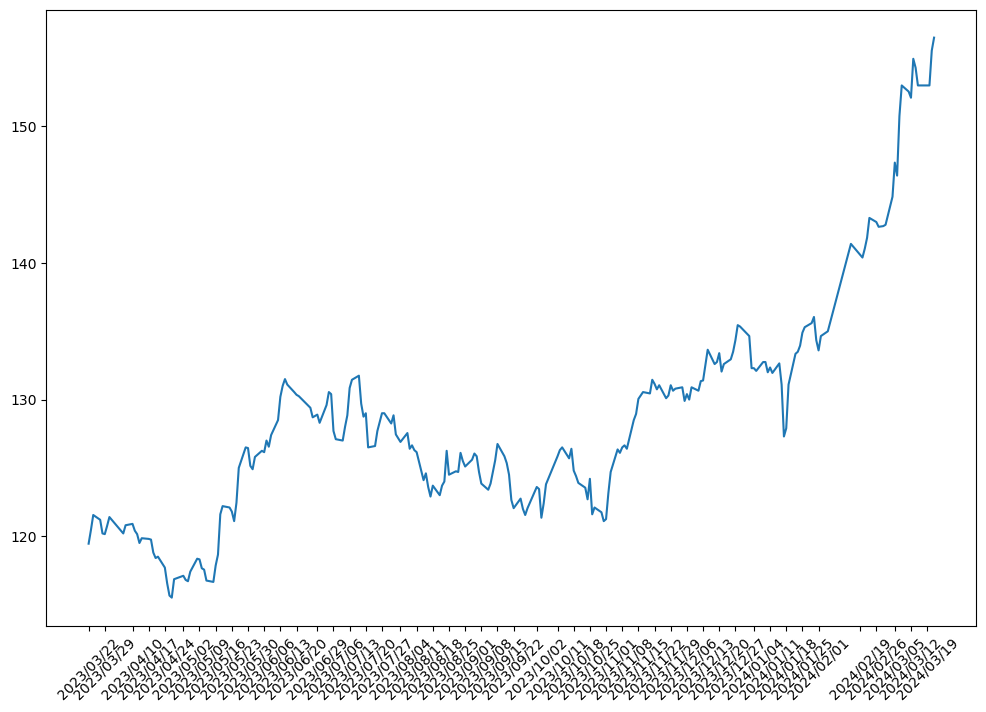

In [372]:
LABEL =  "Low"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.005580308437347412
1 0.005002597570419312
2 0.006018170118331909
3 0.0043854150176048275
4 0.004901672601699829
5 0.004272412657737732
6 0.004824357032775879
7 0.00548625648021698
8 0.003014472723007202
9 0.0026460567116737364
10 0.00246439591050148
11 0.006916621327400207
12 0.0051200085878372196
13 0.004549106061458588
14 0.0033947482705116274
15 0.00526611864566803
16 0.00549050509929657
17 0.006946423053741455
18 0.0026799568533897398
19 0.002644142806529999
20 0.0044531521201133725
21 0.0027275195717811583
22 0.005923273563385009
23 0.002177644819021225
24 0.00518397331237793
25 0.002929387092590332
26 0.005100626349449158
27 0.005194885134696961
28 0.005606977939605713
29 0.003082515001296997
30 0.004794898629188538
31 0.0034708547592163085
32 0.005231263041496277
33 0.004486964643001556
34 0.004476532340049744
35 0.0037959158420562745
36 0.003322395980358124
37 0.0016458964347839356
38 0.002381475567817688
39 0.0034870055317878725
40 0.0022192777693271636
41 0.00202342808246

318 0.00034270115196704864
319 0.00028960952535271643
320 0.0003577079251408577
321 0.0003865332901477814
322 0.000257026981562376
323 0.00029028274118900296
324 0.0002524494007229805
325 0.00016284333541989328
326 0.00029578857123851776
327 0.00030056215822696683
328 0.00020012523978948593
329 0.00025451332330703733
330 0.0002461080625653267
331 0.00021811384707689285
332 0.0002990742214024067
333 0.00033955905586481095
334 0.0003502722829580307
335 0.0002642020583152771
336 0.00032154325395822525
337 0.0002054685726761818
338 0.0003664251789450645
339 0.00029599083587527274
340 0.0002836254239082336
341 0.0002867472916841507
342 0.0002732992172241211
343 0.00029746374115347863
344 0.0003366340696811676
345 0.0002034463919699192
346 0.0002707723341882229
347 0.00023195484653115272
348 0.0002768598310649395
349 0.00024032730609178544
350 0.0003239860758185387
351 0.00026323335245251653
352 0.0002865481749176979
353 0.0002646172232925892
354 0.0003284216299653053
355 0.00024424733594059

629 0.0002704885229468346
630 0.0002856782451272011
631 0.00027712194249033926
632 0.0003102603182196617
633 0.0002613026462495327
634 0.00025007648393511774
635 0.00031078431755304336
636 0.0003183946758508682
637 0.00021184328943490982
638 0.0002151426486670971
639 0.00024077964946627616
640 0.00022810611873865126
641 0.000295290257781744
642 0.0002280786447227001
643 0.00026582395657896994
644 0.0001966487430036068
645 0.0002498282864689827
646 0.0001831083931028843
647 0.0003401816636323929
648 0.00021578380838036538
649 0.0002990897186100483
650 0.0001797497645020485
651 0.00034709926694631577
652 0.000158695075660944
653 0.00028793487697839734
654 0.00017368946224451066
655 0.00022988798096776008
656 0.0002550100535154343
657 0.0002761499769985676
658 0.00023480987176299095
659 0.00021689847111701965
660 0.00021885296329855918
661 0.00031226180493831634
662 0.00025328967720270154
663 0.00029586950317025187
664 0.0002540462464094162
665 0.00025220436975359917
666 0.000268588457256

937 0.00022887229919433595
938 0.00023535188287496567
939 0.00020936641842126847
940 0.00012176518328487873
941 0.00015967601910233498
942 0.00027514269575476644
943 0.0001965746283531189
944 0.00022522503510117532
945 0.00024752579629421233
946 0.0001374183502048254
947 0.00019680999219417572
948 0.0002081459201872349
949 0.0001655900664627552
950 0.00025094324722886086
951 0.00026925455778837204
952 0.00023215116932988168
953 0.000182627160102129
954 0.0002296014316380024
955 0.0002684745937585831
956 0.00021843621507287026
957 0.00016653858125209809
958 0.00021037092432379722
959 0.00020573366433382034
960 0.00019160471856594086
961 0.00015090424567461015
962 0.00018768707290291785
963 0.00020403437316417693
964 0.0001743648201227188
965 0.00012539025396108628
966 0.00026408566161990166
967 0.00023334354162216187
968 0.00018986914306879044
969 0.00021359017118811608
970 0.00018515709787607194
971 0.00018838819116353989
972 0.00018513506278395654
973 0.0002514725551009178
974 0.00023

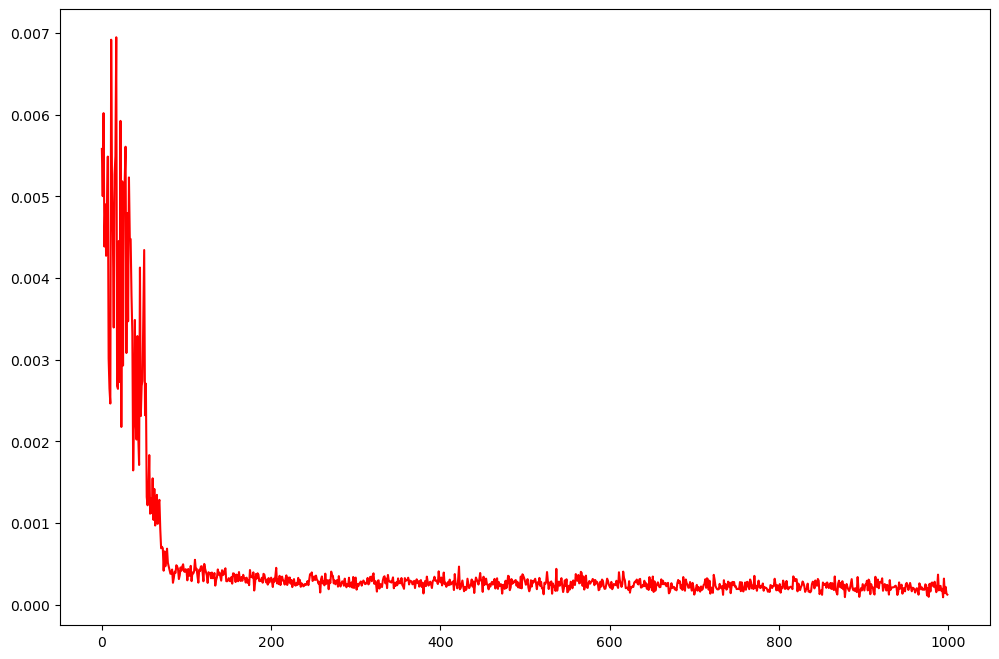

In [373]:
#訓練
# rnns[LABEL] = torch.load('rnn.pkl')

losses = []

optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [374]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

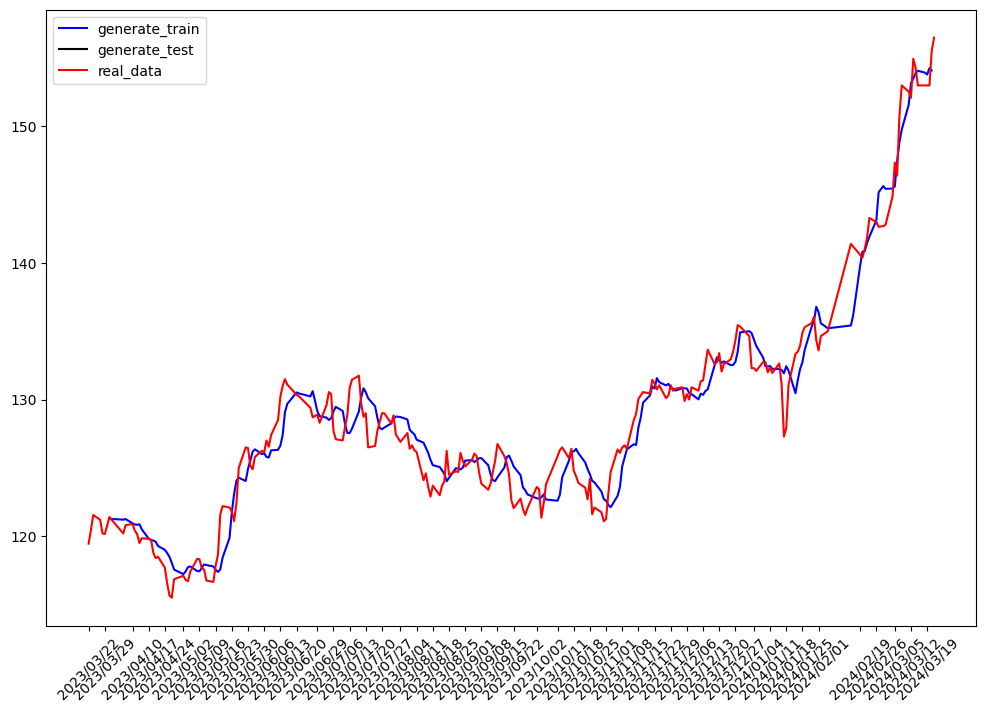

In [375]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


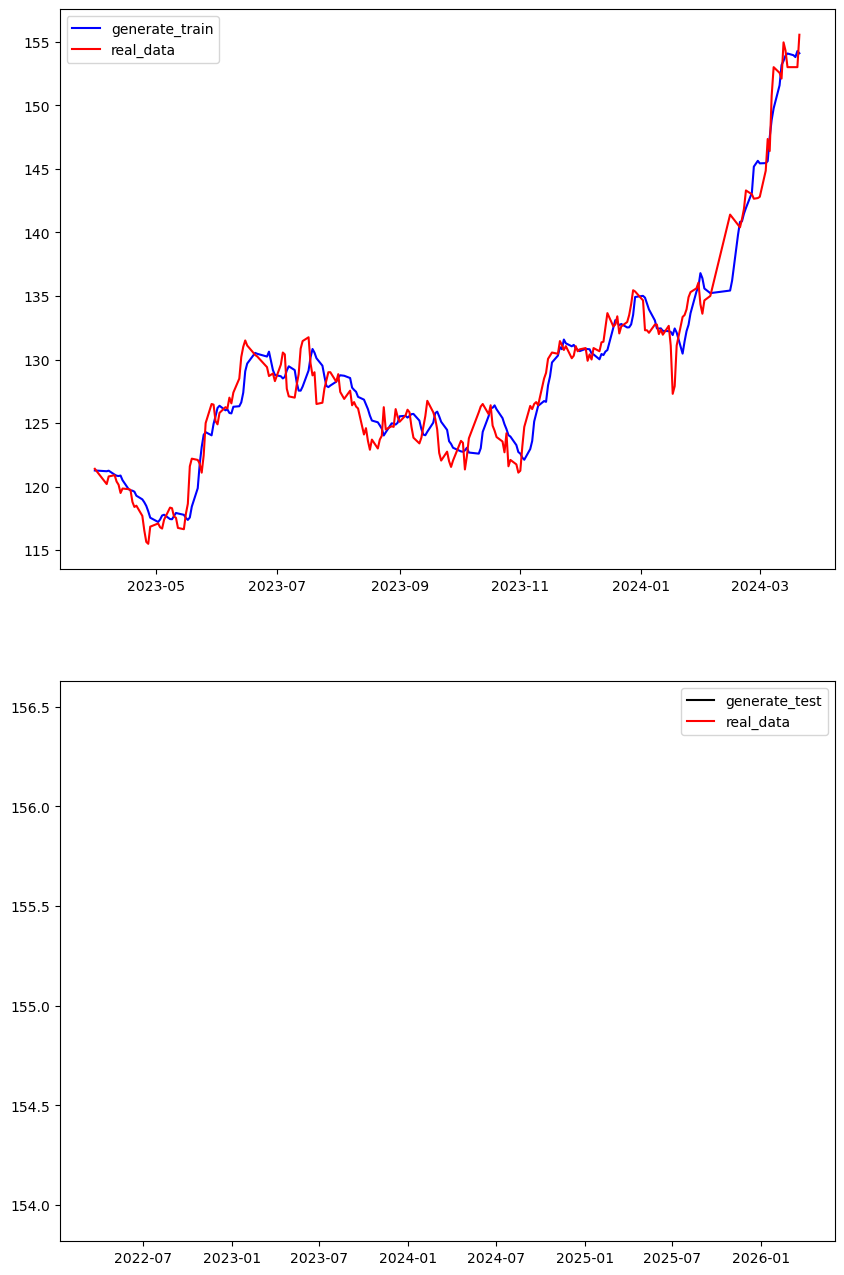

In [376]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Close

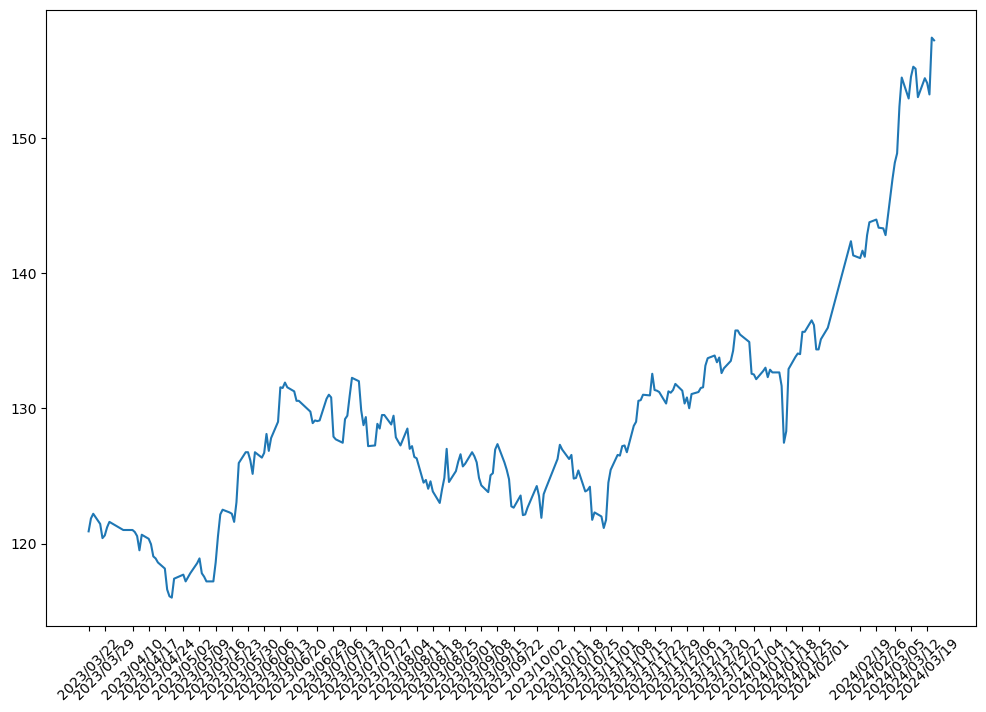

In [377]:
LABEL =  "Close"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.004936567842960358
1 0.0037724652886390684
2 0.006819599866867065
3 0.00605923593044281
4 0.0034747830033302306
5 0.0032029807567596435
6 0.0070250540971755985
7 0.006193251013755798
8 0.0039189115166664125
9 0.00831247091293335
10 0.0032944026589393615
11 0.006626284718513489
12 0.002792551517486572
13 0.003365271985530853
14 0.00399894654750824
15 0.004173018932342529
16 0.006212812066078186
17 0.0045461696386337284
18 0.003386012315750122
19 0.0033542117476463317
20 0.003382109999656677
21 0.005774405002593994
22 0.003597794473171234
23 0.004378974735736847
24 0.003235970139503479
25 0.004696448147296905
26 0.00310500830411911
27 0.004322071671485901
28 0.0067260837554931644
29 0.0038060575723648073
30 0.003075278103351593
31 0.0023339837789535522
32 0.00447934627532959
33 0.0026846489310264586
34 0.004571443796157837
35 0.0022195608913898467
36 0.0033945661783218385
37 0.003058740794658661
38 0.0026572808623313905
39 0.0032998505234718323
40 0.0035100987553596495
41 0.002857926

318 0.0002950865775346756
319 0.0002316901832818985
320 0.0003184620663523674
321 0.00037369512021541597
322 0.00029238425195217134
323 0.00036982689052820204
324 0.0003595197945833206
325 0.00029084138572216034
326 0.000309308972209692
327 0.00018889816477894782
328 0.00022733643651008607
329 0.00023064836859703063
330 0.0002253895252943039
331 0.00023882711306214333
332 0.00028022510930895804
333 0.0003071820363402367
334 0.00025621611624956133
335 0.0002748509868979454
336 0.00027964524924755095
337 0.00031509507447481156
338 0.00021494872868061066
339 0.000317731648683548
340 0.0002159886434674263
341 0.00025850258767604826
342 0.00020645301789045333
343 0.000273367203772068
344 0.0003394521027803421
345 0.0002888787537813187
346 0.00029229726642370223
347 0.00025608208030462263
348 0.00028369434177875517
349 0.00034388042986392974
350 0.00028011778369545936
351 0.0002870198339223862
352 0.00028511635959148406
353 0.00028849277645349503
354 0.0001823508180677891
355 0.0002485419996

628 0.0002454659342765808
629 0.00024112645536661148
630 0.0003103318065404892
631 0.000325503870844841
632 0.0002415723353624344
633 0.0002569747343659401
634 0.00028817273676395416
635 0.0003445391356945038
636 0.00016936158761382103
637 0.0002480677887797356
638 0.00014578253030776976
639 0.0003102010488510132
640 0.0002168179862201214
641 0.00023815270513296126
642 0.00024400942027568817
643 0.00026771869510412217
644 0.0003458647429943085
645 0.0003339342772960663
646 0.00029100336134433745
647 0.00024161377921700478
648 0.00029023341834545136
649 0.00031469278037548064
650 0.000305180549621582
651 0.0001997014693915844
652 0.0002497772127389908
653 0.0002166525274515152
654 0.00034599229693412783
655 0.0002821839228272438
656 0.00019980186596512794
657 0.00020126678049564361
658 0.00026953019201755526
659 0.0002391217090189457
660 0.0002899357676506042
661 0.00021642524749040603
662 0.00022770991548895836
663 0.00020046984776854514
664 0.00016562847420573235
665 0.000213659778237

938 0.0002674279361963272
939 0.00028745707124471664
940 0.00020505104213953019
941 0.00017724568024277688
942 0.00021029673516750335
943 0.0001836007833480835
944 0.0003445420414209366
945 0.00037513274699449537
946 0.00017325185239315034
947 0.00028837399557232854
948 0.00024314643815159798
949 0.00020538534969091415
950 0.0002138885110616684
951 0.00018725540488958358
952 0.00023458130657672883
953 0.0002476431056857109
954 0.00013355948962271214
955 0.00018409695476293564
956 0.000161888487637043
957 0.0001888897269964218
958 0.00021341567859053611
959 0.0001990332454442978
960 0.00015972349792718886
961 0.0002320573478937149
962 0.00018351061269640922
963 0.00022085634991526605
964 0.0002989507094025612
965 0.00013704468496143817
966 0.00018269812688231468
967 0.00029926184564828875
968 0.0001817431300878525
969 0.00023286743089556694
970 0.0003098514676094055
971 0.00024826714769005776
972 0.0002007131837308407
973 0.00028681524097919466
974 0.00021235788241028786
975 0.000448746

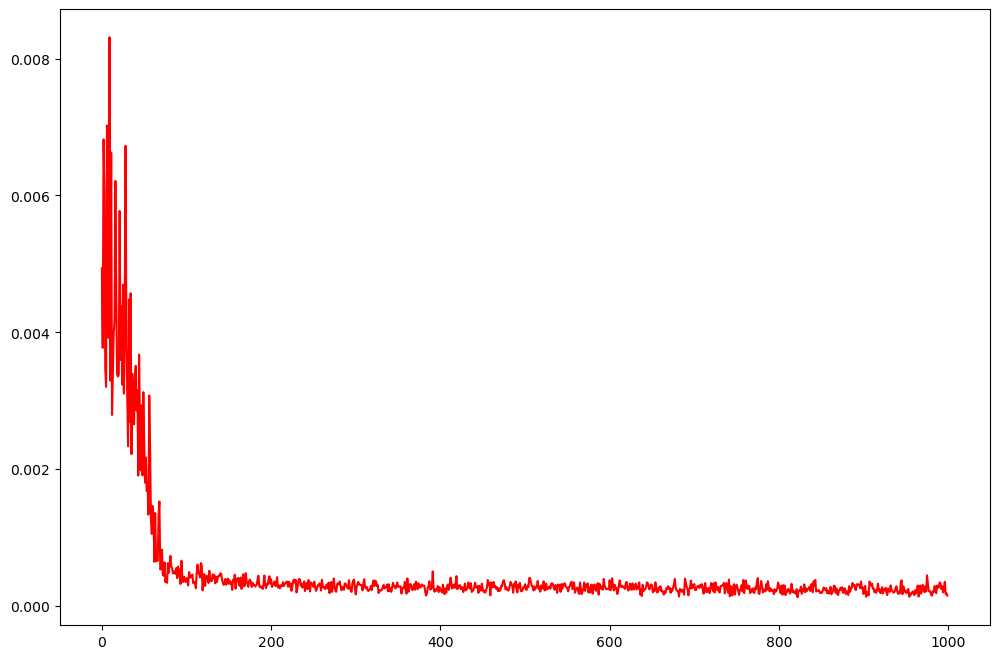

In [378]:
#訓練
# rnns[LABEL] = torch.load('rnn.pkl')

losses = []



optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [379]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

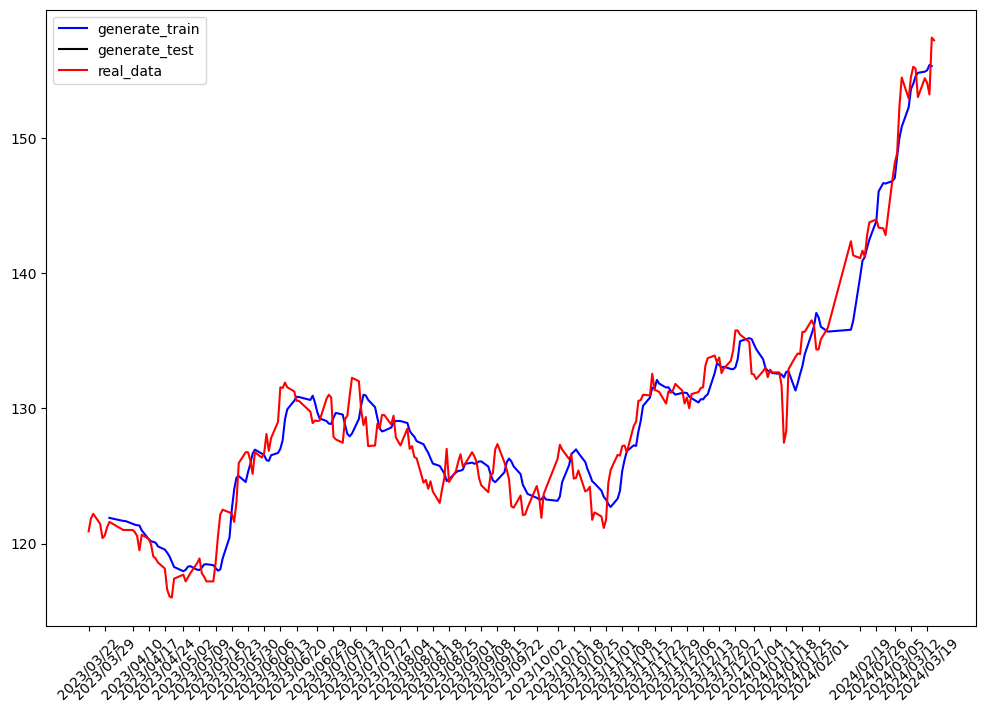

In [380]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


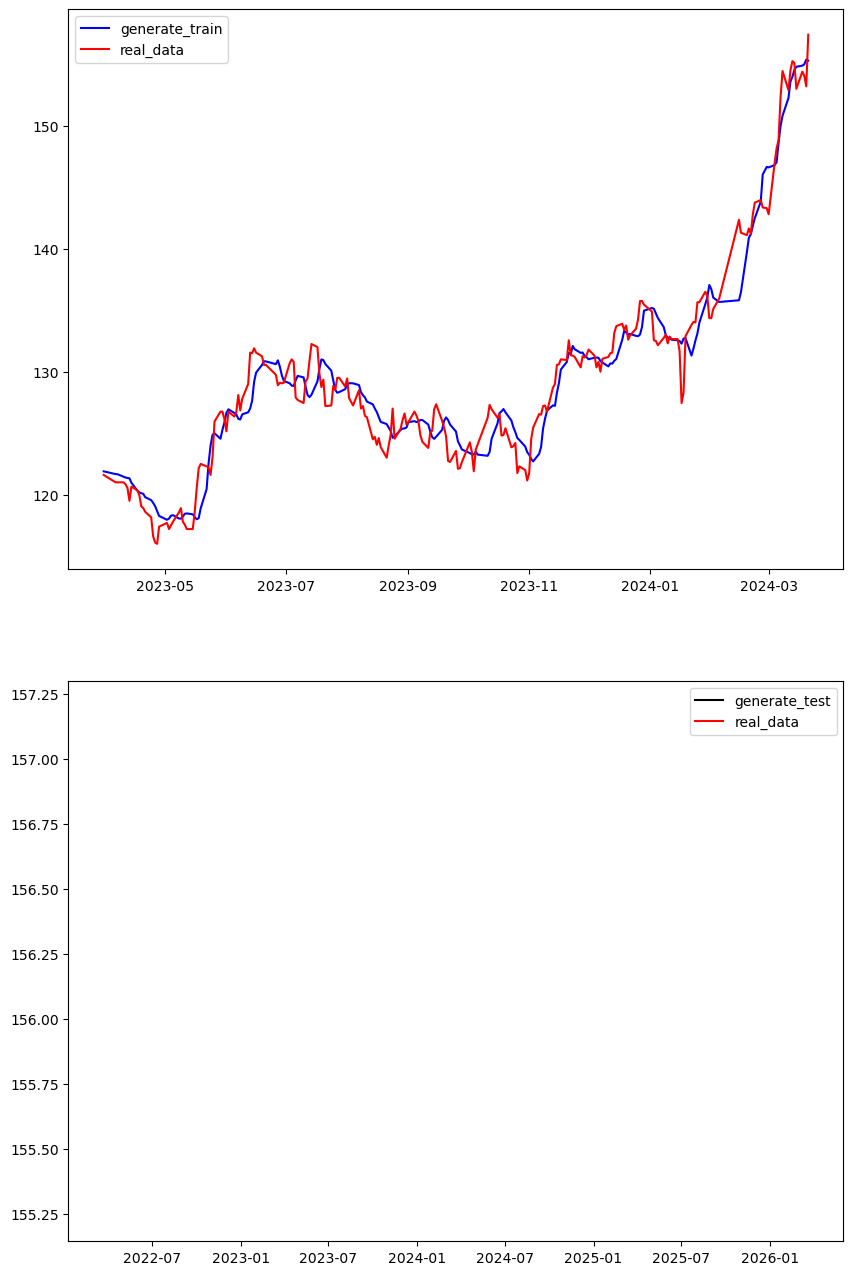

In [381]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Adj Close

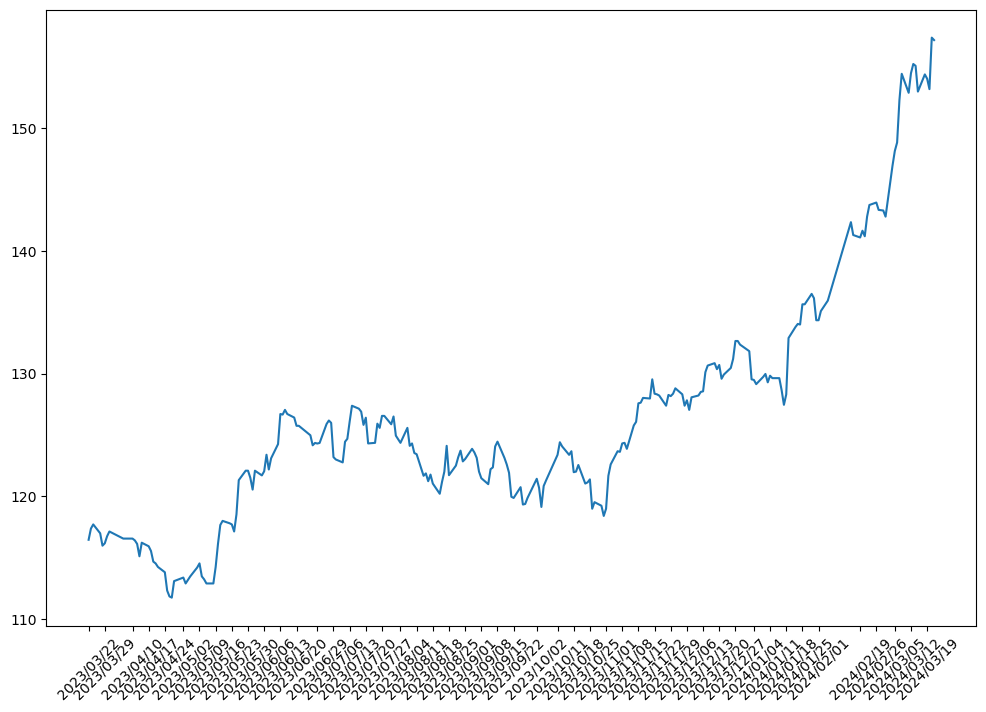

In [382]:
LABEL =  "Adj Close"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.0033285582065582277
1 0.00613946259021759
2 0.005865437984466553
3 0.00529637336730957
4 0.005242239832878113
5 0.0035642459988594055
6 0.003963736295700074
7 0.00523407518863678
8 0.004177981913089752
9 0.005236002802848816
10 0.006931862831115723
11 0.0016419260203838347
12 0.004729457497596741
13 0.004599317908287048
14 0.004236179888248443
15 0.005807954072952271
16 0.004721977412700653
17 0.003660954236984253
18 0.004862805008888245
19 0.0034962502121925355
20 0.0020576232671737672
21 0.006317076683044434
22 0.0020654745399951934
23 0.0037810403108596803
24 0.005119807720184326
25 0.006016728878021241
26 0.0030591168999671934
27 0.0038371244072914123
28 0.005361618399620056
29 0.004100168347358704
30 0.002370589077472687
31 0.004533418416976929
32 0.003784043490886688
33 0.00512454092502594
34 0.001445557177066803
35 0.0015666060149669646
36 0.006014310121536255
37 0.003038644194602966
38 0.003555735349655151
39 0.0025254616141319273
40 0.002846628427505493
41 0.00241623476147

318 0.0002667287550866604
319 0.0003230775520205498
320 0.0003090234845876694
321 0.0003668742626905441
322 0.0002412765845656395
323 0.00021361224353313446
324 0.0002813132666051388
325 0.00017501555383205413
326 0.00023389168083667755
327 0.00025199310854077337
328 0.00039833486080169677
329 0.0003798585757613182
330 0.0002726730890572071
331 0.00021200187504291534
332 0.0002684230916202068
333 0.0002666785940527916
334 0.000270019993185997
335 0.00030938880518078805
336 0.00029292749240994453
337 0.0003035878762602806
338 0.00016046935692429543
339 0.00014110810123384
340 0.00022241003811359405
341 0.0002709946595132351
342 0.00026430971920490267
343 0.0003141673281788826
344 0.0003249945864081383
345 0.00034207820892333984
346 0.00028978338465094564
347 0.00021976357325911522
348 0.00022767633199691773
349 0.00022631151601672174
350 0.00032103117555379865
351 0.00020740922540426254
352 0.00017624067142605783
353 0.0003037437051534653
354 0.00026409612968564033
355 0.000224886462092

628 0.00018058469519019127
629 0.00024112949147820473
630 0.00026419274508953093
631 0.0002523703500628471
632 0.00030850520357489586
633 0.0001734813302755356
634 0.00018664687871932983
635 0.0002682083286345005
636 0.00019216665998101235
637 0.00019961509853601454
638 0.00023803342133760452
639 0.0002669406495988369
640 0.00018728256225585937
641 0.00018635842949151992
642 0.00024432435631752017
643 0.000210480485111475
644 0.00018339820206165314
645 0.00018896453082561492
646 0.000198439359664917
647 0.00021880129352211953
648 0.0003594885766506195
649 0.0002252858877182007
650 0.00017181120812892914
651 0.00023225180804729463
652 0.0001566554419696331
653 0.00020653124898672103
654 9.50459111481905e-05
655 0.0002469121664762497
656 0.00018020691350102426
657 0.0002844059467315674
658 0.0004441607743501663
659 0.0002882709726691246
660 0.00015114905312657356
661 0.0003513278067111969
662 0.00018720181658864022
663 0.00018036045134067535
664 0.00018575983121991158
665 0.0003004518151

936 0.00019629186019301414
937 0.00016965297982096672
938 0.00010648094117641448
939 0.00012486125342547894
940 0.00014540293253958224
941 0.00016457360237836838
942 0.00015387098304927348
943 0.00012724452652037143
944 0.00021530475467443466
945 0.00016118546947836875
946 0.000176517590880394
947 0.00017242761328816413
948 0.0001739881932735443
949 0.00017213815823197365
950 0.0001490694936364889
951 0.0001698027178645134
952 0.00017776034772396088
953 0.00022004742175340652
954 0.0001239286083728075
955 0.00024332575500011445
956 0.0001488098129630089
957 0.00016690514981746674
958 0.00023194707930088043
959 0.00012127877213060856
960 0.0001083429716527462
961 0.00011460844427347184
962 0.00017522690817713737
963 0.0001493427623063326
964 0.00025306280702352523
965 0.00011377255432307721
966 0.00017475686967372895
967 9.308632463216781e-05
968 0.00014930408447980881
969 0.0001760072261095047
970 0.00015482742339372634
971 0.00025333013385534284
972 0.00018998494371771812
973 0.000151

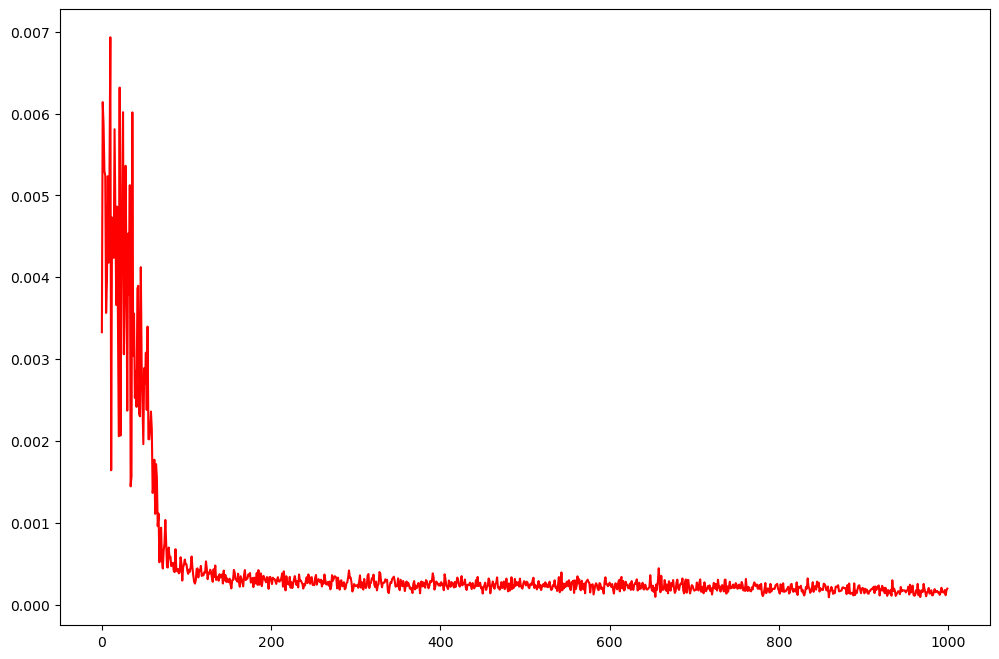

In [383]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []

rnn = LSTM()

optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [384]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

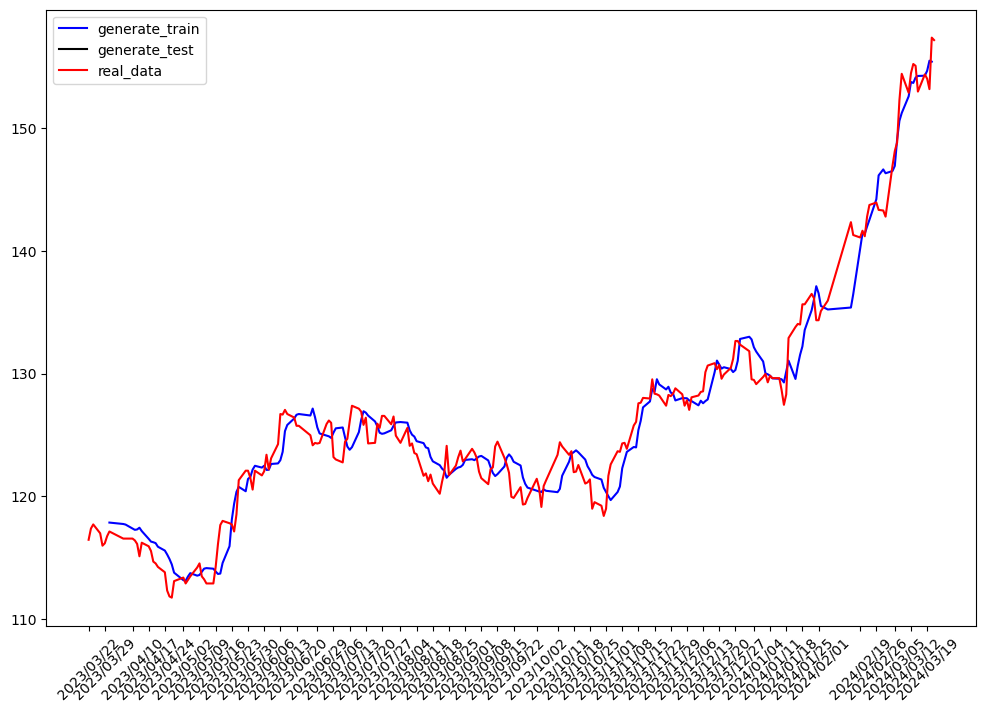

In [385]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


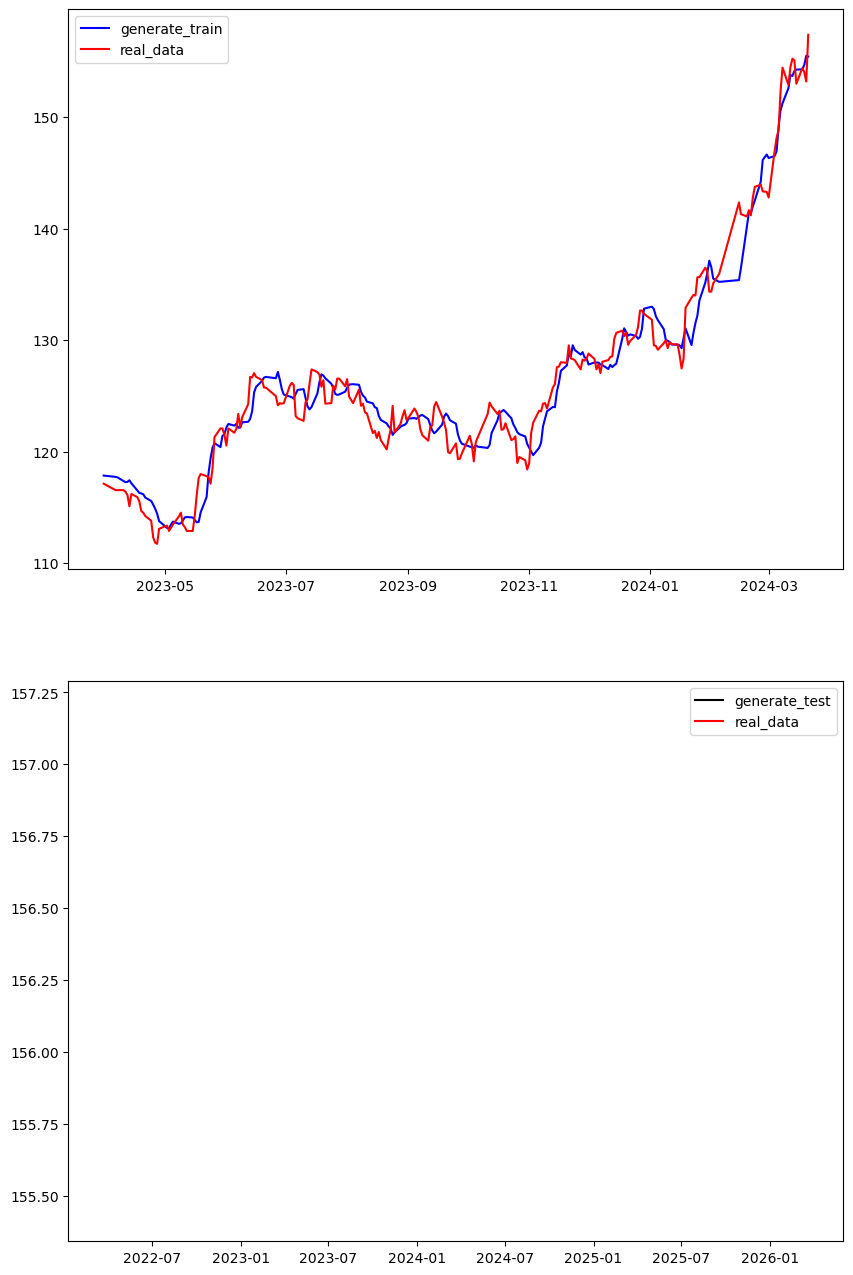

In [386]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Volume

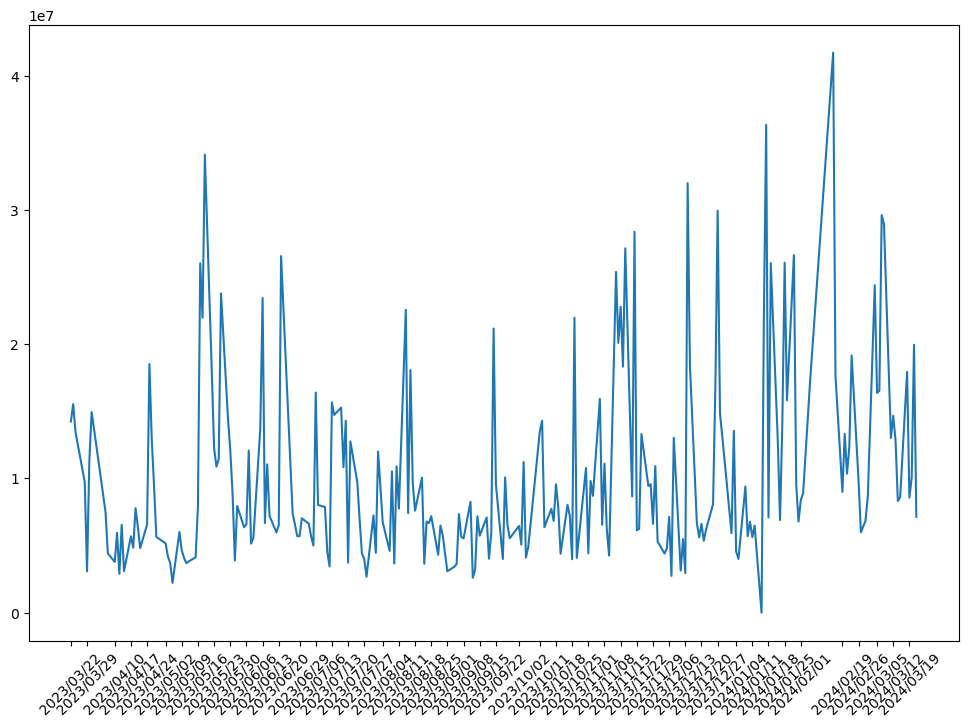

In [387]:
LABEL =  "Volume"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.0053420960903167725
1 0.004701983034610748
2 0.004294610619544983
3 0.004214357137680053
4 0.003546362519264221
5 0.003442159295082092
6 0.0056651771068572995
7 0.007433362603187561
8 0.006706794500350952
9 0.005285547971725464
10 0.008707876801490783
11 0.003735322058200836
12 0.0020857810974121093
13 0.006462706923484802
14 0.004611793756484985
15 0.002942420542240143
16 0.006748499274253845
17 0.00855162262916565
18 0.005364024639129638
19 0.0042605817317962645
20 0.004458273649215698
21 0.0031565403938293457
22 0.005166715979576111
23 0.0037630951404571534
24 0.006070510745048523
25 0.00497594028711319
26 0.003806891143321991
27 0.002417483627796173
28 0.006434996128082276
29 0.004458695650100708
30 0.006909632086753845
31 0.006488311290740967
32 0.004871440529823304
33 0.007757831215858459
34 0.00403477281332016
35 0.00692358136177063
36 0.00501354455947876
37 0.0054672503471374515
38 0.0022891466319561004
39 0.0034340158104896545
40 0.004665401875972748
41 0.00336175739765167

330 0.0036690500378608703
331 0.003730093538761139
332 0.004837491810321808
333 0.003479422926902771
334 0.004909182786941528
335 0.003979085087776184
336 0.0027388560771942137
337 0.006846261620521546
338 0.006200128197669983
339 0.003863722085952759
340 0.0043705528974533085
341 0.0036528459191322326
342 0.003864956796169281
343 0.004756454229354858
344 0.004821143746376037
345 0.004068499505519867
346 0.007570958733558655
347 0.003075958490371704
348 0.004738689064979553
349 0.005331137180328369
350 0.0042242401838302615
351 0.00613362193107605
352 0.005092505812644959
353 0.0029810976982116697
354 0.00483907699584961
355 0.005491094589233398
356 0.004811955690383911
357 0.0035476547479629515
358 0.0019115769863128661
359 0.004242229759693145
360 0.004308970868587494
361 0.008957862854003906
362 0.0034584486484527588
363 0.0031977134943008425
364 0.00883533239364624
365 0.004821981787681579
366 0.005490977764129639
367 0.005204259157180786
368 0.0045498725771904
369 0.00377200871706

656 0.0038401830196380616
657 0.002567563354969025
658 0.0021244314312934874
659 0.004098536074161529
660 0.003623829185962677
661 0.004954621493816376
662 0.003154379427433014
663 0.004063310623168945
664 0.008416317701339722
665 0.0027807146310806275
666 0.004510945081710816
667 0.005112296938896179
668 0.005316857099533081
669 0.002960912585258484
670 0.0027469515800476072
671 0.0060695064067840575
672 0.0037212929129600524
673 0.003304225504398346
674 0.002787691056728363
675 0.005964357852935791
676 0.0023937180638313295
677 0.004623859226703644
678 0.002792583107948303
679 0.003633098900318146
680 0.004077491164207458
681 0.002107510566711426
682 0.006644412279129029
683 0.003418940305709839
684 0.005499632358551026
685 0.004884778559207916
686 0.007701762318611145
687 0.005925976037979126
688 0.003766639530658722
689 0.006198766231536865
690 0.0023885300755500795
691 0.0026206830143928527
692 0.005348126888275146
693 0.0049027946591377256
694 0.0034165513515472413
695 0.00318196

980 0.004708689451217651
981 0.0037935474514961243
982 0.004340125322341919
983 0.004112522304058075
984 0.0034862133860588075
985 0.005230408310890198
986 0.0059776479005813595
987 0.0033636730909347534
988 0.004164111614227295
989 0.0032468760013580323
990 0.004765809774398804
991 0.003315637707710266
992 0.0026581421494483947
993 0.004201700091362
994 0.0036844462156295776
995 0.005630450844764709
996 0.002978557348251343
997 0.004243362247943878
998 0.004041739702224731
999 0.003127993941307068


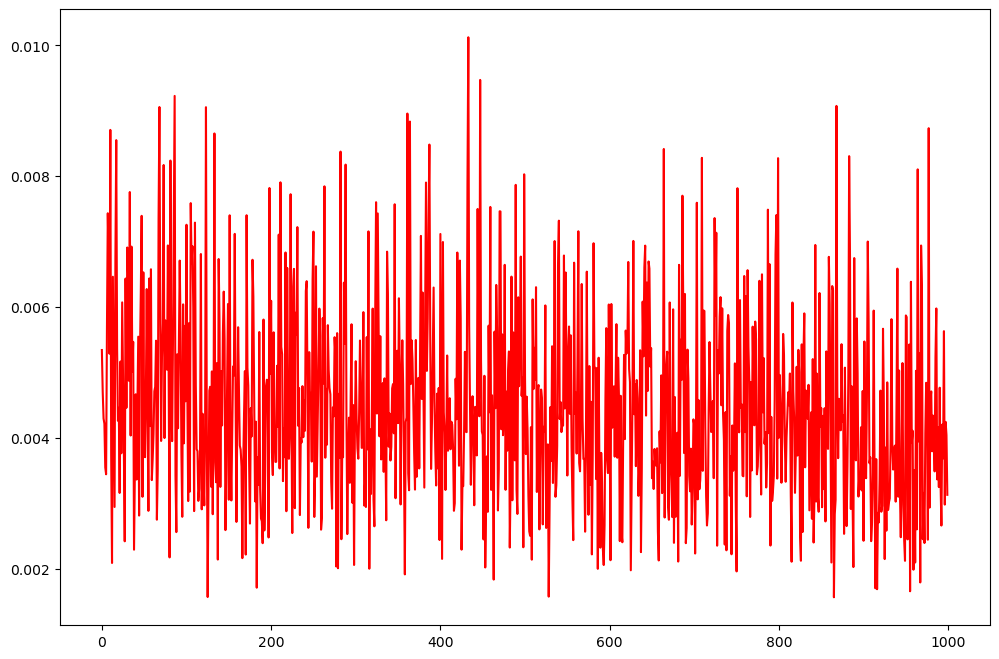

In [388]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []

optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
torch.save(rnns[LABEL], f'rnns{LABEL}_mul_close.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [389]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

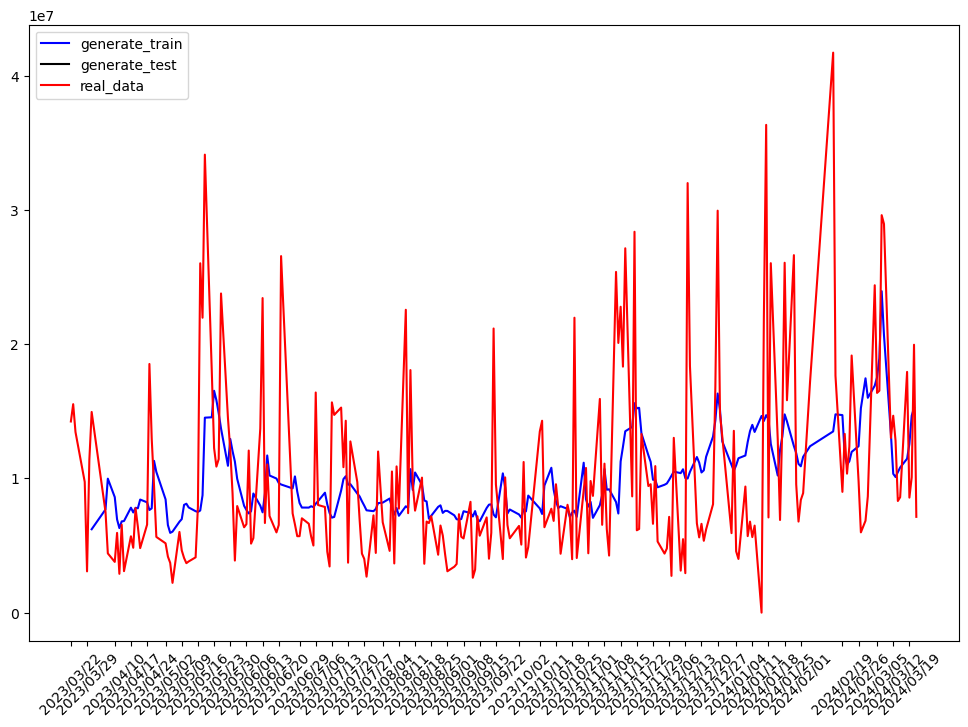

In [390]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


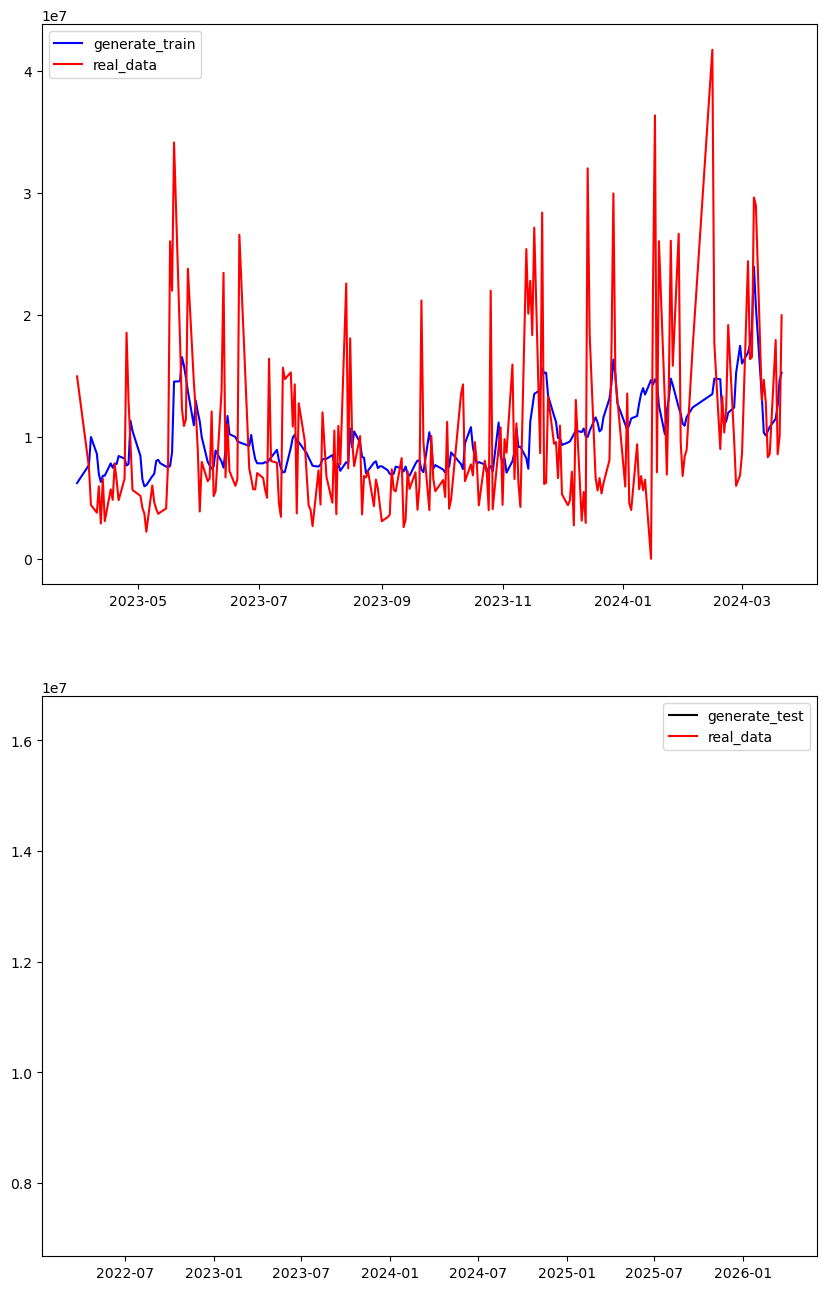

In [391]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# FINAL

In [396]:
ansdf=df.copy()
ansdf.tail()

,Open,High,Low,Close,Adj Close,Volume
2024-03-18,153.00,154.50,153.00,154.40,154.40,17937768
2024-03-19,153.40,154.55,153.00,154.05,154.05,8569789
2024-03-20,154.20,155.30,153.00,153.20,153.20,10080404
2024-03-21,155.55,157.70,155.55,157.40,157.40,19960806
2024-03-22,157.50,158.25,156.50,157.20,157.20,7137094


In [397]:
#預測五天
for p in range(5):
    newday=[]
    for (i,lab) in enumerate(FEATURES):
        
#         print(i, lab)
        all_series = np.array(ansdf[lab].tolist())
#         print(all_series)
        train_mean = all_series.mean()
        train_std = all_series.std()
        all_series_std = (all_series - train_mean) / train_std
        all_series_std = torch.Tensor(all_series_std)
        
        ans_f = torch.tensor(ansdf[-242:].values)
#         print(ans_f.dim())
        ans_f = ans_f.unsqueeze(0)
        ans_f = ans_f.float()
        
        out1, (h_n,c_n) = rnns[lab].predict(ans_f)
        
        tmp=round(out1.detach().flatten()[-1].item()* train_std + train_mean,3)
        if i>=5:
            tmp=int(round(out1.detach().flatten()[-1].item()* train_std + train_mean))
        newday.append(tmp)
        print(newday)
    
    
    ansdf.loc[len(ansdf)]=newday
ansdf.tail()   

[152.358]
[152.358, 136.197]
[152.358, 136.197, 137.579]
[152.358, 136.197, 137.579, 139.147]
[152.358, 136.197, 137.579, 139.147, 159.02]
[152.358, 136.197, 137.579, 139.147, 159.02, 27073086]
[152.766]
[152.766, 136.218]
[152.766, 136.218, 137.618]
[152.766, 136.218, 137.618, 139.195]
[152.766, 136.218, 137.618, 139.195, 159.863]
[152.766, 136.218, 137.618, 139.195, 159.863, 27306743]
[153.178]
[153.178, 136.239]
[153.178, 136.239, 137.657]
[153.178, 136.239, 137.657, 139.244]
[153.178, 136.239, 137.657, 139.244, 160.721]
[153.178, 136.239, 137.657, 139.244, 160.721, 27541626]
[153.595]
[153.595, 136.26]
[153.595, 136.26, 137.696]
[153.595, 136.26, 137.696, 139.292]
[153.595, 136.26, 137.696, 139.292, 161.594]
[153.595, 136.26, 137.696, 139.292, 161.594, 27777739]
[154.015]
[154.015, 136.281]
[154.015, 136.281, 137.734]
[154.015, 136.281, 137.734, 139.34]
[154.015, 136.281, 137.734, 139.34, 162.483]
[154.015, 136.281, 137.734, 139.34, 162.483, 28015094]


,Open,High,Low,Close,Adj Close,Volume
244,152.358,136.197,137.579,139.147,159.020,27073086.0
245,152.766,136.218,137.618,139.195,159.863,27306743.0
246,153.178,136.239,137.657,139.244,160.721,27541626.0
247,153.595,136.260,137.696,139.292,161.594,27777739.0
248,154.015,136.281,137.734,139.340,162.483,28015094.0


In [394]:
# #預測五天DATALOADER
# for p in range(5):
#     newday=[]
#     for (i,lab) in enumerate(FEATURES):
        
# #         print(i, lab)
#         #dataLOADER
#         test_feature, test_label, df_index= getTestData(ansdf, FEATURES, lab, days_before=DAYS_BEFORE, train_end=-1)
#         # flatern each day in train data
#         test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
#         test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
#         # 创建 dataloader
#         test_set = TrainSet(test_feature_tensor, test_label_tensor)
#         test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
        
#         # 对所有的数据进行相同的归一化
#         all_series = np.array(ansdf[lab].tolist())
#         train_mean = all_series.mean()
#         train_std = all_series.std()
#         all_series_std = (all_series - train_mean) / train_std
#         all_series_std = torch.Tensor(all_series_std)

#         for tx, ty in test_loader:
#             out, (h_n,c_n) = rnns[LABEL].predict(tx)
            
#             tmp=round(out.detach().flatten()[-1].item()* train_std + train_mean,3)
#             if i>=5:
#                 tmp=int(round(out1.detach().flatten()[-1].item()* train_std + train_mean))
#             newday.append(tmp)
#             print(newday)
    
    
#     ansdf.loc[len(ansdf)]=newday
# ansdf.tail()   

In [395]:
# all_series = np.array(df["Close"].tolist())
# train_mean = all_series.mean()
# train_std = all_series.std()
# all_series_std = (all_series - train_mean) / train_std
# all_series_std = torch.Tensor(all_series_std)

# ans=[]

# ans_f = torch.tensor(df[-7:].values)
# ans_f = ans_f.unsqueeze(0)
# ans_f = ans_f.float()
# out1, (h_n,c_n) = rnns[LABEL].predict(ans_f)

# print(out1.detach().flatten()[-1] * train_std + train_mean)

# # for tx, ty in ans_loader:
# # #     print(type(tx))
# # #     print(tx.dim())
# # #     print(tx)
# # #     print(type(ty))
# #     out, (h_n,c_n) = rnn.predict(tx)
# #     ans.append(out.detach().flatten()[-1] * train_std + train_mean)

# print(ans)
